In [1]:
import cv2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

import random

2024-06-26 16:35:27.941705: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 16:35:28.072370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrad

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/usr/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/usr/lib/python3.12/site-packages/tornado/platform/asyncio.py", l

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



AttributeError: `np.complex_` was removed in the NumPy 2.0 release. Use `np.complex128` instead.

In [11]:
x_train_dir = os.path.join("./dataset/images/", 'training')
x_valid_dir = os.path.join("./dataset/images/", 'validation')
x_test_dir = os.path.join("./dataset/images/", 'testing')

y_train_dir = os.path.join("./dataset/annotations/", 'training')
y_valid_dir = os.path.join("./dataset/annotations/", 'validation')
y_test_dir = os.path.join("./dataset/annotations/", 'testing')

In [12]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['void','keyway']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 1)
        
        # we only care about blue channel for label
        blue, green, red = cv2.split(mask)
        mask = cv2.merge([blue])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

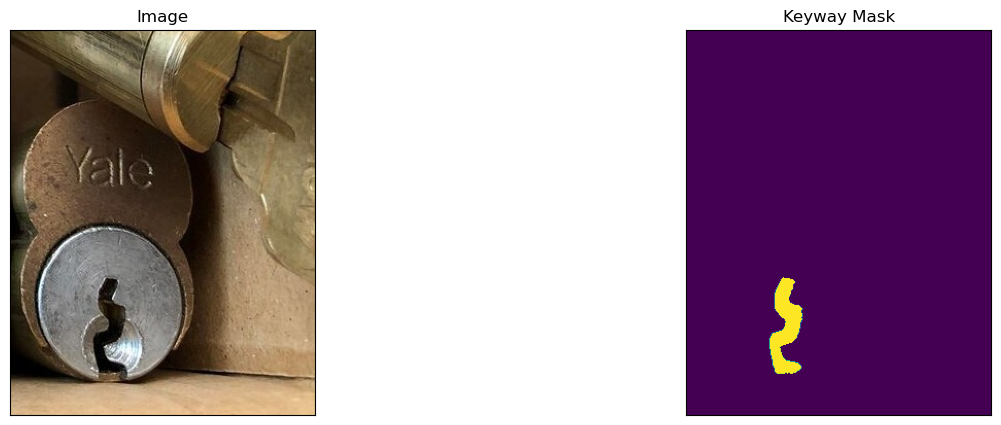

In [7]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['void','keyway'])

image, mask = random.choice(dataset)# get some sample
visualize(
    image=image, 
    keyway_mask=mask[..., 1].squeeze()
)

In [13]:
width = 384

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.ShiftScaleRotate(p=1),
        A.RandomBrightnessContrast(p=0.8),
        A.LongestMaxSize(int(width * 1.5)),
        A.PadIfNeeded(width, width),
        A.RandomCrop(width=width, height=width),
        
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.LongestMaxSize(int(width*1.5)),
        A.PadIfNeeded(width, width),
        A.RandomCrop(width=width, height=width),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


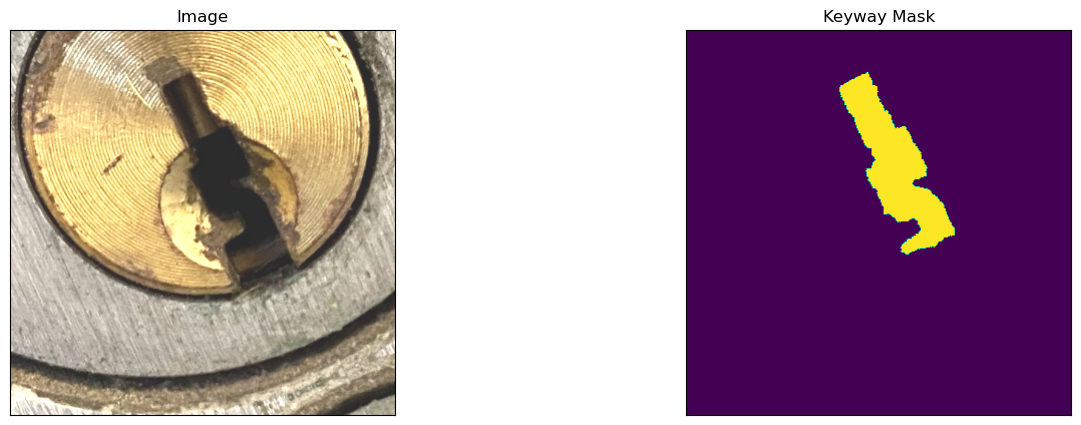

In [14]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['void', 'keyway'], augmentation=get_training_augmentation())

image, mask = random.choice(dataset) # get some sample
visualize(
    image=image, 
    #void_mask=mask[..., 0].squeeze(),
    keyway_mask=mask[..., 1].squeeze(),
)

In [15]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [16]:
import segmentation_models as sm

ModuleNotFoundError: No module named 'keras.engine'

In [12]:
BACKBONE = 'resnet18'
BATCH_SIZE = 4
CLASSES = ['keyway']
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:
sm.Unet(BACKBONE)

In [ ]:
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [11]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
jacard_loss = sm.losses.JaccardLoss()
total_loss = jacard_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

NameError: name 'n_classes' is not defined

In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) # TODO: figure out what batch_size means for validation

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, width, width, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, width, width, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

NameError: name 'n_classes' is not defined

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

NameError: name 'history' is not defined

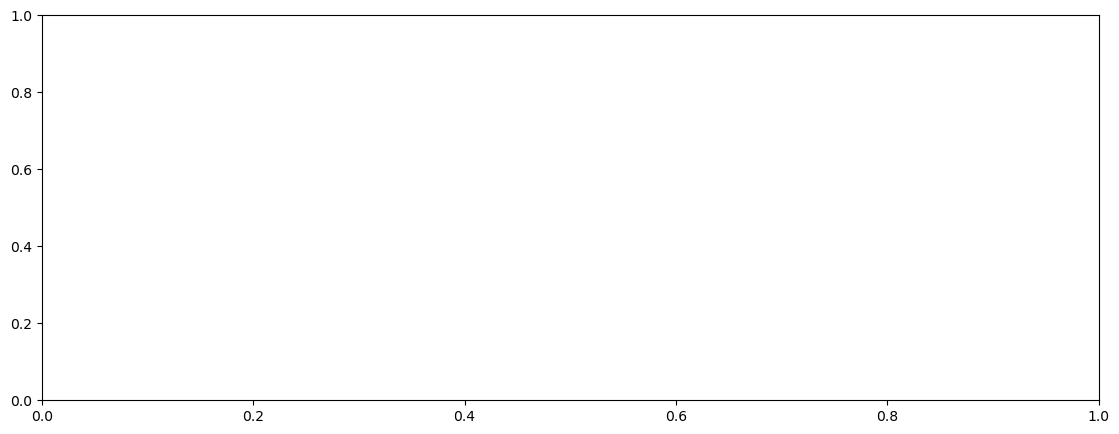

In [13]:


# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [14]:


# load best weights
model.load_weights('best_model.h5') 



NameError: name 'model' is not defined

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
for i in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
for i in range(len(dataset)):
    
    image, gt_mask = dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 1].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    

In [ ]:
cv2.destroyAllWindows()

In [ ]:
sc1 = cv2.imread("./refrence/test.png")
sc1 = cv2.cvtColor(sc1, cv2.COLOR_BGR2GRAY)
sc1 = cv2.threshold(sc1,128,255,cv2.THRESH_BINARY_INV)[1]

In [ ]:
cv2.imwrite("test.png",sc1)

In [ ]:
# This programs calculates the orientation of an object.
# The input is an image, and the output is an annotated image
# with the angle of otientation for each object (0 to 180 degrees)
 
import cv2 as cv
from math import atan2, cos, sin, sqrt, pi
import numpy as np
 
# Load the image
img = cv.imread("./refrence/test.png")
 
# Was the image there?
if img is None:
  print("Error: File not found")
  exit(0)
  
# Convert image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
# Convert image to binary
_, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
 
# Find all the contours in the thresholded image
contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

for i, c in enumerate(contours):
 
  # Calculate the area of each contour
  area = cv.contourArea(c)

  print(area)
 
  # cv.minAreaRect returns:
  # (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(c)
  rect = cv.minAreaRect(c)
  box = cv.boxPoints(rect)
  box = np.int0(box)
 
  # Retrieve the key parameters of the rotated bounding box
  center = (int(rect[0][0]),int(rect[0][1])) 
  width = int(rect[1][0])
  height = int(rect[1][1])
  angle = int(rect[2])
 
     
  if width < height:
    angle = 90 - angle
  else:
    angle = -angle
         
  label = "  Rotation Angle: " + str(angle) + " degrees"
  textbox = cv.rectangle(img, (center[0]-35, center[1]-25), 
    (center[0] + 295, center[1] + 10), (255,255,255), -1)
  #cv.putText(img, label, (center[0]-50, center[1]),  cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv.LINE_AA)
  cv.drawContours(img,[box],0,(0,0,255),2)
  
# Save the output image to the current directory
cv.imwrite("test.png", img)

In [ ]:
cv2.imwrite("sc1.png",sc1)

for i in range(len(test_dataset)):
    image, gt_mask = dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    _,result = cv2.threshold(pr_mask[0]*255,128,255,cv2.THRESH_BINARY)
    result = result.astype(np.uint8)
    
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(result, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    print(compare_shapes(sc1, eroded))